freedofs [12 13 14 15 16 17 18 19 20 21 22 23]
[[ 1.03846154e+08  3.75000000e+07  0.00000000e+00 -1.15384615e+06
   3.84615385e+06 -1.34615385e+06 -6.34615385e+07 -2.88461538e+06
   0.00000000e+00 -1.15384615e+06  3.84615385e+06 -6.73076923e+05
  -5.19230769e+07 -3.75000000e+07  0.00000000e+00 -5.76923077e+05
   1.92307692e+06 -6.73076923e+05  1.15384615e+07  2.88461538e+06
   0.00000000e+00 -5.76923077e+05  1.92307692e+06 -1.34615385e+06]
 [ 3.75000000e+07  1.03846154e+08  0.00000000e+00 -3.84615385e+06
   1.15384615e+06 -1.34615385e+06  2.88461538e+06  1.15384615e+07
   0.00000000e+00 -1.92307692e+06  5.76923077e+05 -1.34615385e+06
  -3.75000000e+07 -5.19230769e+07  0.00000000e+00 -1.92307692e+06
   5.76923077e+05 -6.73076923e+05 -2.88461538e+06 -6.34615385e+07
   0.00000000e+00 -3.84615385e+06  1.15384615e+06 -6.73076923e+05]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.000000

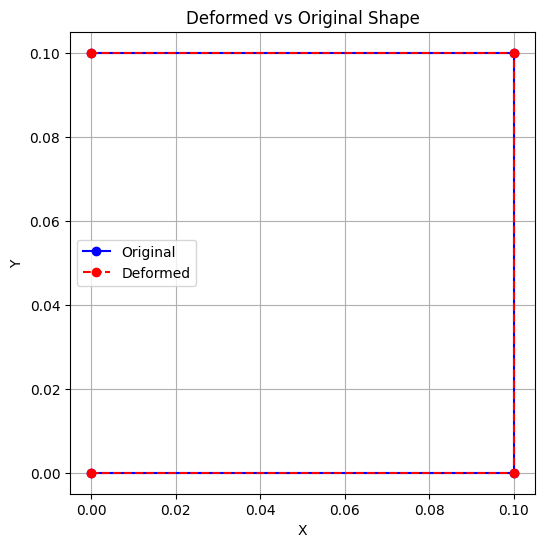

[    0.             0.             0.             0.
     0.             0.             0.             0.
     0.             0.             0.             0.
     0.             0.         -9629.62962963     0.
     0.             0.            -0.             0.
     0.             0.             0.             0.        ]


In [11]:
import numpy as np
import matplotlib.pyplot as plt

# Material properties
E = 210e9       # Young's modulus (Pa)
nu = 0.3        # Poisson's ratio
t = 0.001        # Thickness (m)

# Elasticity matrix for plane stress
def elasticity_matrix(E, nu):
    C = (E / (1 - nu**2)) * np.array([
        [1, nu, 0],
        [nu, 1, 0],
        [0, 0, (1 - nu) / 2]
    ])
    return C

# Shape functions for quadrilateral shell (MITC4)
def shape_functions_quad(xi, eta):
    N = np.array([
        0.25 * (1 - xi) * (1 - eta),
        0.25 * (1 + xi) * (1 - eta),
        0.25 * (1 + xi) * (1 + eta),
        0.25 * (1 - xi) * (1 + eta)
    ])
    
    dN_dxi = np.array([
        [-0.25 * (1 - eta), -0.25 * (1 - xi)],
        [0.25 * (1 - eta), -0.25 * (1 + xi)],
        [0.25 * (1 + eta), 0.25 * (1 + xi)],
        [-0.25 * (1 + eta), 0.25 * (1 - xi)]
    ])
    
    return N, dN_dxi

# Stiffness matrix for quadrilateral shell (MITC4)
def stiffness_matrix_quad(nodes, t, E, nu):
    C = elasticity_matrix(E, nu)
    Ke = np.zeros((24, 24))  # 4 nodes × 6 DOF each

    # Gauss quadrature points for quadrilateral integration
    gauss_pts = [(-1/np.sqrt(3), -1/np.sqrt(3)), (1/np.sqrt(3), -1/np.sqrt(3)),
                 (1/np.sqrt(3), 1/np.sqrt(3)), (-1/np.sqrt(3), 1/np.sqrt(3))]

    for xi, eta in gauss_pts:
        N, dN_dxi = shape_functions_quad(xi, eta)

        # Compute Jacobian
        J = np.dot(dN_dxi.T, nodes[:, :2])
        J_inv = np.linalg.inv(J)
        detJ = np.linalg.det(J)

        # Strain-displacement matrix B
        B = np.zeros((3, 24))
        for i in range(4):
            dN_dx = J_inv @ dN_dxi[i]
            B[:, i*6:(i+1)*6] = np.array([
                [dN_dx[0], 0, 0, 0, -N[i], 0],  # Membrane + bending coupling
                [0, dN_dx[1], 0, N[i], 0, 0],  # Membrane + bending
                [dN_dx[1], dN_dx[0], 0, 0, 0, N[i]]  # Shear strain component
            ])

        Ke += t * detJ * (B.T @ C @ B)

    return Ke

# Define a quadrilateral shell element's node coordinates (x, y, z)
nodes_quad = np.array([
    [0, 0, 0], [0.1, 0, 0], [0.1, 0.1, 0], [0, 0.1, 0]
])

# Compute stiffness matrix
K_quad = stiffness_matrix_quad(nodes_quad, t, E, nu)

# Define load vector (point force at node 3 in z-direction)
F = np.zeros(24)
F[14] = -1000  # Applying force in z-direction at node 3

# Apply boundary conditions (fix two nodes)
fixed_dofs = np.array([
    0, 1, 2, 3, 4, 5,  # Node 0 fully fixed
    6, 7, 8, 9, 10, 11  # Node 1 fully fixed
])
free_dofs = np.setdiff1d(np.arange(24), fixed_dofs)

print ("freedofs",free_dofs)

print (K_quad)

# Reduce system to free DOFs
K_reduced = K_quad[np.ix_(free_dofs, free_dofs)]
F_reduced = F[free_dofs]

# Add small stiffness regularization to avoid singularities
K_reduced += np.eye(len(K_reduced)) * 1e-9 * np.max(K_reduced)

# Solve for displacements
U_reduced = np.linalg.solve(K_reduced, F_reduced)

# Expand displacement vector to include fixed DOFs (zero displacement)
U = np.zeros(24)
U[free_dofs] = U_reduced

# Extract deformed node positions
scale_factor = 500000  # Scale deformation for visualization
deformed_nodes = nodes_quad + scale_factor * U.reshape(4, 6)[:, :3]

# Plot original vs deformed shape
plt.figure(figsize=(6, 6))
plt.plot(nodes_quad[:, 0], nodes_quad[:, 1], 'bo-', label="Original")
plt.plot(deformed_nodes[:, 0], deformed_nodes[:, 1], 'ro--', label="Deformed")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.title("Deformed vs Original Shape")
plt.grid()
plt.show()

print(U)
